In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import  torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
import sys
import seaborn as sns
sys.path.append('/home/aggelos-i3/ForecastingLib/')
from tsutils import SequenceSpliter
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
class TimeSeriesDataSet(Dataset):

    def __init__(self, datafile, features, lookback, feature_to_reconstruct):
        self.features = features
        self.feature_to_reconstruct = feature_to_reconstruct
        self.lookback = lookback

        df = pd.read_csv(datafile, usecols=self.features, delimiter='\t')
        df = df.rolling(lookback).mean().dropna()
        spliter = SequenceSpliter(lookback, 1)
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df)
        df.iloc[:, :] = scaled
        X, _ = spliter.fit_transform(df.values)
        X = np.swapaxes(X, 1,2)
        self.target_idx = df.columns.get_loc(self.feature_to_reconstruct)
        self.dataset = torch.Tensor(X)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        return torch.Tensor(self.dataset[item])


workers = 4

batch_size = 128

lookback = 128

noise_size = 10

num_epochs = 2

lr = 0.0002

beta1 = 0.5

features = ['voltage [V]',
            'acceleration (actual) [m/(s*s)]',
            'tractive effort (actual) [kN]',
            'track-earth voltage [V]',
            'speed (actual) [km/h]',
            'current [A]',
            'energy balance [kWh]',
            'way (actual) [km]',
            'line and running resistance [kN]',
            'train configuration [1]',
            'energy input [kWh]',
            'train configuration [1]',
            'usable braking energy [kWh]',
            'used braking energy [kWh]'
            ]

nb_features = len(features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = TimeSeriesDataSet("~/Downloads/simu Elbas/7h33NO/7hnz0038.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)

validation_dataset = TimeSeriesDataSet("~/Downloads/simu Elbas/7h33NO/7hnz0040.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)


In [4]:
class Encoder(nn.Module):
    """This is the encoder part of the autoencoder"""
    
    def __init__(self, lookback):
        super().__init__()
        self.lookback = lookback
        self.dilations = [2**i for i in range(1,int(np.log2(lookback/2)))]
        self.conv1 = nn.Conv1d(13, self.lookback, kernel_size=3, stride=1, padding=1)
        self.layers = nn.ModuleList([])
        i=2
        for dilation in self.dilations[:-1]:
            self.layers.append(nn.Conv1d(self.lookback//(i//2), self.lookback//i, kernel_size=3, stride=2, dilation=dilation, padding=dilation))
            i *= 2
        self.activation = nn.ReLU()

    
    def forward(self, x):
        x = self.activation(self.conv1(x))
        for layer in self.layers[:-1]:
            x = layer(x)
            #using detach because i do not want the gfradients of mu and var
            mu, var = torch.mean(x, [0,2]).detach(), torch.var(x, [0,2]).detach()
            x = self.activation(F.batch_norm(x, mu, var))
        x = self.layers[-1](x)

        return x
        

In [26]:
class Decoder(nn.Module):
    def __init__(self, lookback, in_channels):
        """The decoder part of the autoencoder """
        
        super().__init__()
        self.layers = nn.ModuleList([])
        while in_channels != lookback//2:
            self.layers.append(nn.ConvTranspose1d(in_channels, 2*in_channels,kernel_size=in_channels, stride=1))
            in_channels *= 2
        self.conv6 = nn.ConvTranspose1d(in_channels, 13, 8, stride=2, padding=0)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        x = self.conv6(x)
        return x

In [31]:
class AE(nn.Module):
    def __init__(self, lookback, hidden_channels):
        super().__init__()
        self.encoder = Encoder(lookback)
        self.decoder = Decoder(lookback, hidden_channels)
    def forward(self, x):
        code = self.encoder(x)
        self.code = code
        #noisy_code = code + torch.randn(code.shape).detach()
        reconstructed = self.decoder(code)
        return reconstructed

In [32]:
ae = AE(lookback, 8).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters())
history_train_loss = []
history_val_loss = []
dataloaders = {'train': train_dataloader,
              'validation': validation_dataloader}

In [103]:
for epoch in tqdm(range(100)):
    for mode, dataloader in dataloaders.items():
        for batch in dataloader:
                if mode == 'train':
                    ae.train()
                    optimizer.zero_grad()
                    reconstructed = ae(batch)
                    train_loss = criterion(reconstructed, batch)
                    train_loss.backward()
                    optimizer.step()
                    history_train_loss.append(train_loss.item())

               # else:
                #    ae.eval()
                 #   reconstructed = ae(batch)
                  #  val_loss = criterion(reconstructed, batch)
                   # history_val_loss.append(val_loss.item())
    if epoch%3 == 0:
        print(f"Epoch: {epoch+1}, Train_Loss: {train_loss.item()}")
            


  1%|          | 1/100 [00:00<01:32,  1.07it/s]

Epoch: 1, Train_Loss: 0.27497392892837524


  4%|▍         | 4/100 [00:03<01:28,  1.08it/s]

Epoch: 4, Train_Loss: 0.4487355053424835


  7%|▋         | 7/100 [00:06<01:25,  1.09it/s]

Epoch: 7, Train_Loss: 0.2925366163253784


 10%|█         | 10/100 [00:09<01:22,  1.09it/s]

Epoch: 10, Train_Loss: 0.2315571904182434


 13%|█▎        | 13/100 [00:11<01:20,  1.08it/s]

Epoch: 13, Train_Loss: 0.24087461829185486


 16%|█▌        | 16/100 [00:14<01:16,  1.09it/s]

Epoch: 16, Train_Loss: 0.7074612379074097


 19%|█▉        | 19/100 [00:17<01:15,  1.08it/s]

Epoch: 19, Train_Loss: 0.19971603155136108


 22%|██▏       | 22/100 [00:20<01:16,  1.02it/s]

Epoch: 22, Train_Loss: 0.3124275505542755


 25%|██▌       | 25/100 [00:23<01:13,  1.02it/s]

Epoch: 25, Train_Loss: 0.6132276058197021


 28%|██▊       | 28/100 [00:26<01:07,  1.07it/s]

Epoch: 28, Train_Loss: 0.35293394327163696


 31%|███       | 31/100 [00:29<01:03,  1.08it/s]

Epoch: 31, Train_Loss: 0.5838383436203003


 34%|███▍      | 34/100 [00:31<01:00,  1.08it/s]

Epoch: 34, Train_Loss: 0.33858737349510193


 37%|███▋      | 37/100 [00:34<01:00,  1.04it/s]

Epoch: 37, Train_Loss: 0.7472842335700989


 40%|████      | 40/100 [00:37<00:57,  1.05it/s]

Epoch: 40, Train_Loss: 0.19503898918628693


 43%|████▎     | 43/100 [00:40<00:54,  1.05it/s]

Epoch: 43, Train_Loss: 0.21536819636821747


 46%|████▌     | 46/100 [00:43<00:55,  1.02s/it]

Epoch: 46, Train_Loss: 0.32857078313827515


 49%|████▉     | 49/100 [00:46<00:51,  1.02s/it]

Epoch: 49, Train_Loss: 0.32164323329925537


 52%|█████▏    | 52/100 [00:49<00:49,  1.03s/it]

Epoch: 52, Train_Loss: 0.2199459969997406


 55%|█████▌    | 55/100 [00:52<00:45,  1.02s/it]

Epoch: 55, Train_Loss: 0.1555020809173584


 58%|█████▊    | 58/100 [00:55<00:39,  1.05it/s]

Epoch: 58, Train_Loss: 0.482254296541214


 61%|██████    | 61/100 [00:58<00:36,  1.07it/s]

Epoch: 61, Train_Loss: 0.49232399463653564


 64%|██████▍   | 64/100 [01:01<00:33,  1.07it/s]

Epoch: 64, Train_Loss: 0.2334502786397934


 67%|██████▋   | 67/100 [01:04<00:31,  1.03it/s]

Epoch: 67, Train_Loss: 0.3238006830215454


 70%|███████   | 70/100 [01:07<00:29,  1.02it/s]

Epoch: 70, Train_Loss: 0.18941599130630493


 73%|███████▎  | 73/100 [01:09<00:25,  1.05it/s]

Epoch: 73, Train_Loss: 0.3960469365119934


 76%|███████▌  | 76/100 [01:12<00:22,  1.08it/s]

Epoch: 76, Train_Loss: 0.244949609041214


 79%|███████▉  | 79/100 [01:15<00:19,  1.09it/s]

Epoch: 79, Train_Loss: 0.24814271926879883


 82%|████████▏ | 82/100 [01:18<00:16,  1.09it/s]

Epoch: 82, Train_Loss: 0.24100908637046814


 85%|████████▌ | 85/100 [01:20<00:13,  1.08it/s]

Epoch: 85, Train_Loss: 0.21790045499801636


 88%|████████▊ | 88/100 [01:23<00:11,  1.07it/s]

Epoch: 88, Train_Loss: 0.18906734883785248


 91%|█████████ | 91/100 [01:26<00:08,  1.08it/s]

Epoch: 91, Train_Loss: 0.21106532216072083


 94%|█████████▍| 94/100 [01:29<00:05,  1.08it/s]

Epoch: 94, Train_Loss: 0.1907486915588379


 97%|█████████▋| 97/100 [01:32<00:02,  1.07it/s]

Epoch: 97, Train_Loss: 0.20956511795520782


100%|██████████| 100/100 [01:34<00:00,  1.08it/s]

Epoch: 100, Train_Loss: 0.15209120512008667


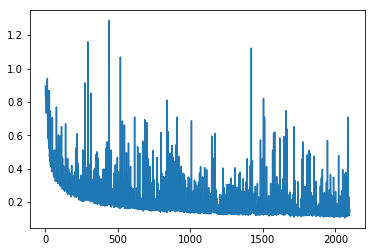

In [104]:
plt.plot(history_train_loss)
plt.plot(history_val_loss)

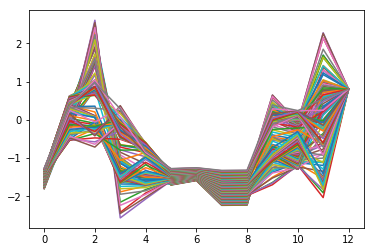

In [105]:
plt.plot(train_dataset[0].detach().numpy())

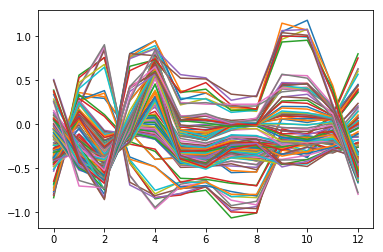

In [106]:
plt.plot(ae(train_dataset[0:1]).detach().numpy()[0])

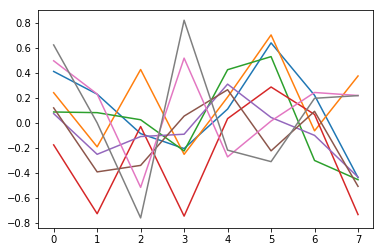

In [107]:
plt.plot(ae.code.detach().numpy()[0])

In [108]:
def reconstruction_loss(generated, original, mode='mean'):
    if mode == 'mean':
        return np.mean((generated.detach().numpy() - original.detach().numpy())**2, axis=(2))
    elif mode == 'max':
        return np.max((generated.detach().numpy() - original.detach().numpy())**2, axis=(2))

In [109]:
reconstructed = ae(train_dataset[:])
reconstruction_error = reconstruction_loss(reconstructed, train_dataset[:])

In [ ]:
faulty_dataset = TimeSeriesDataSet("~/Downloads/simu Elbas/7h33D2/7hnz0040.xls",
                            lookback=lookback,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

In [99]:
reconstructed = ae(faulty_dataset[:])
abnormal_reconstruction_error = reconstruction_loss(reconstructed, faulty_dataset[:])

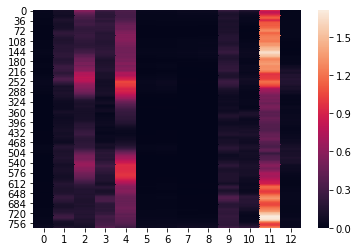

In [100]:
sns.heatmap(abnormal_reconstruction_error)


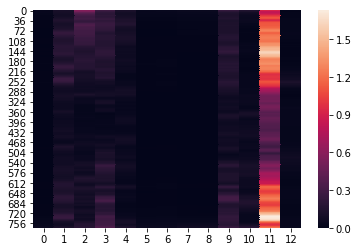

In [101]:
sns.heatmap(reconstruction_error)

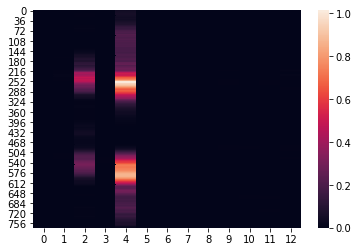

In [102]:
sns.heatmap((reconstruction_error - abnormal_reconstruction_error)**2)

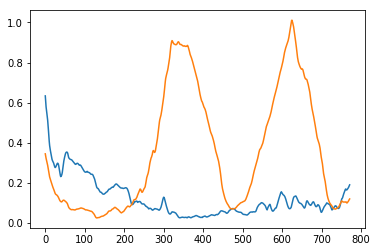

In [97]:
plt.plot(reconstruction_error[:,2])
plt.plot(abnormal_reconstruction_error[:,2])

In [91]:
train_dataset.target_idx

2